In [1]:
import sys
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import os
import matplotlib
import matplotlib.pyplot as plt 
import random
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics 
import tensorflow.contrib.rnn as rnn 
from sklearn.utils import shuffle
from __future__ import division



In [2]:
data = 'data.csv'

In [3]:
print('Reading CSV Data...')
df = pd.read_csv(data)

#Number of positive and negative classes
#print (df.label[df.label == 0].count())
#Create a new feature for normal (non-fraudulent) transactions.

#df.loc[df.label == 0, 'Slip'] = 1
#df.loc[df.label == 1, 'Slip'] = 0



#Rename 'Class' to 'Fraud'.
#df = df.rename(columns={'label': 'Stable'})
#test_df = test_df.rename(columns={'label': 'Stable'})

#Create dataframes of only Fraud and Normal transactions.
#Slip = df[df.Slip == 1]
#Stable = df[df.Stable == 1]

#test_Slip = test_df[test_df.Slip == 1]
#test_Stable = test_df[test_df.Stable == 1]

# Set X_train equal to 80% of the fraudulent transactions.
#X_train = Slip.sample
#count_Slips = len(Slip)

Slip = df[df.label == 0]
Stable = df[df.label == 1]
print ('Number of Stable class examples: ', Stable.label.count())
print ('Numbuer of Unstable class examples: ', Slip.label.count())


Reading CSV Data...
('Number of Stable class examples: ', 58645)
('Numbuer of Unstable class examples: ', 2122)


In [4]:

# Add 80% of the normal transactions to X_train.
X_train = Slip.sample(frac=0.8)
count_Slip = len(X_train)

# Add 80% of the normal transactions to X_train.
X_train = pd.concat([X_train, Stable.sample(frac = 0.8)], axis = 0)

# X_test contains all the transaction not in X_train.
X_test = df.loc[~df.index.isin(X_train.index)]

# Shuffle the dataframes so that the training is done in a random order.
X_train = shuffle(X_train)
X_test = shuffle(X_test)

X_train = X_train.iloc[0:48600, :]
X_test = X_test.iloc[0:12150, :]



print ('Length of train set', len(X_train))
print ('Length of test set', len (X_test))



('Length of train set', 48600)
('Length of test set', 12150)


In [5]:
# Add our target features to y_train and y_test.

#df.loc[df.label == 0, 'Slip'] = 1


y_train = X_train.label
y_test = X_test.label

# Drop target features from X_train and X_test.
X_train = X_train.drop(['label'], axis = 1)
X_test = X_test.drop(['label'], axis = 1)


# Check to ensure all of the training/testing dataframes are of the correct length



In [6]:
num_epochs = 10
total_series_length = len(X_train)
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 2
num_batches = total_series_length//batch_size//truncated_backprop_length
# Network Parameters
num_input = len(X_train)
timesteps = 1
num_hidden = int(len(X_train) * .5)


In [7]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [8]:
# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [9]:
def generateData(x, y):
   
    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

In [10]:
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [11]:
# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], 1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state


In [20]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, logits = logits) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.GradientDescentOptimizer(0.3).minimize(total_loss)
#correct_pred = tf.equal(tf.argmax(predictions_series, 1), tf.argmax(labels, 1))
accuracy=[tf.reduce_mean(tf.cast(predictions,np.float32)) for predictions in predictions_series]

In [13]:

cost_summary = [] # Record cost values for plot

In [14]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(batch_size):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


Instructions for updating:
Use `tf.global_variables_initializer` instead.


/Users/ainur/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ainur/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


('New data, epoch', 0)
('Step', 0, 'Loss', 0.61640477, 'Acc', [0.5, 0.5, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49999997])


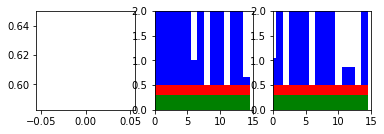

('Step', 100, 'Loss', 0.063248076, 'Acc', [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.5, 0.49999997, 0.5, 0.5, 0.5, 0.5, 0.5])


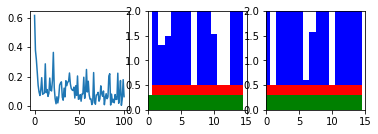

('Step', 200, 'Loss', 0.068380006, 'Acc', [0.5, 0.5, 0.49999997, 0.5, 0.49999997, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])


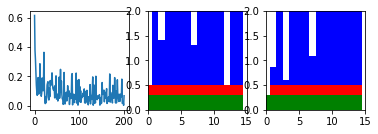

('Step', 300, 'Loss', 0.11357661, 'Acc', [0.5, 0.5, 0.5, 0.5, 0.5, 0.49999994, 0.5, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.5, 0.5, 0.49999997])


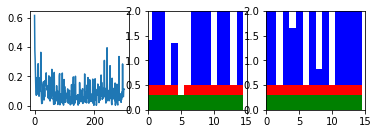

('Step', 400, 'Loss', 0.11680467, 'Acc', [0.5, 0.49999997, 0.49999997, 0.5, 0.50000006, 0.49999997, 0.5, 0.5, 0.49999997, 0.49999997, 0.5, 0.49999997, 0.5, 0.5, 0.5])


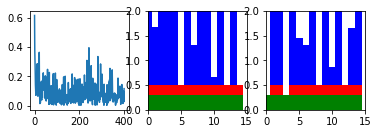

('Step', 500, 'Loss', 0.095846847, 'Acc', [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49999997, 0.5])


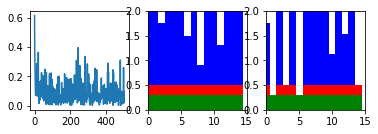

('Step', 600, 'Loss', 0.046141546, 'Acc', [0.49999997, 0.5, 0.49999997, 0.49999997, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49999997, 0.49999997])


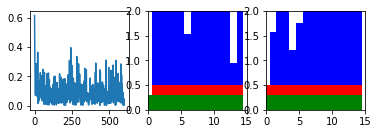

('Step', 700, 'Loss', 0.069012232, 'Acc', [0.49999997, 0.49999997, 0.5, 0.49999997, 0.5, 0.50000006, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])


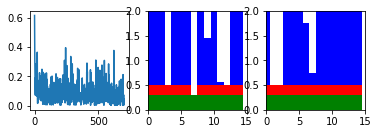

('Step', 800, 'Loss', 0.054282542, 'Acc', [0.5, 0.50000006, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.50000006, 0.5, 0.5, 0.5, 0.5, 0.5])


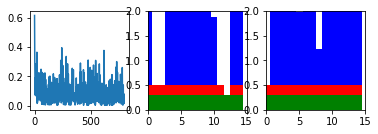

('Step', 900, 'Loss', 0.20528349, 'Acc', [0.49999997, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.50000006, 0.5, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.5, 0.5])


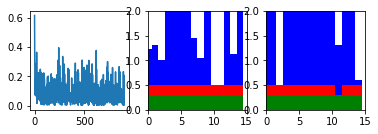

('Step', 1000, 'Loss', 0.036548588, 'Acc', [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.5, 0.49999997, 0.49999997, 0.49999997, 0.5, 0.5])


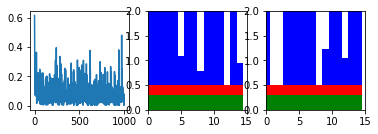

('Step', 1100, 'Loss', 0.041260485, 'Acc', [0.49999997, 0.5, 0.49999997, 0.5, 0.5, 0.49999997, 0.5, 0.5, 0.5, 0.49999997, 0.50000006, 0.5, 0.5, 0.5, 0.5])


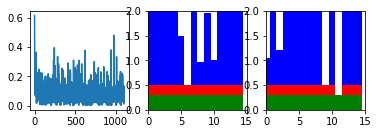

('Step', 1200, 'Loss', 0.14885727, 'Acc', [0.49999997, 0.49999997, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49999997])


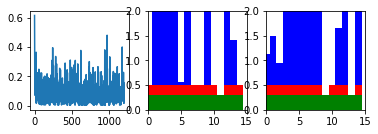

('Step', 1300, 'Loss', 0.055104692, 'Acc', [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.5])


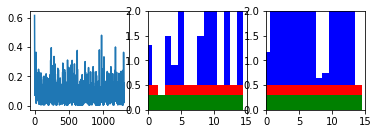

('Step', 1400, 'Loss', 0.052985039, 'Acc', [0.50000006, 0.49999997, 0.5, 0.5, 0.5, 0.5, 0.49999997, 0.50000006, 0.5, 0.5, 0.5, 0.49999997, 0.49999997, 0.5, 0.49999997])


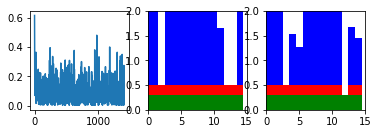

('Step', 1500, 'Loss', 0.0032491423, 'Acc', [0.5, 0.5, 0.50000006, 0.5, 0.5, 0.49999997, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])


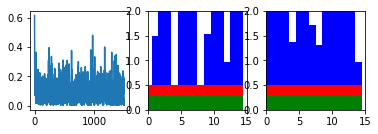

('Step', 1600, 'Loss', 0.0022298098, 'Acc', [0.5, 0.5, 0.5, 0.5, 0.49999997, 0.49999997, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.5, 0.5, 0.5, 0.5])


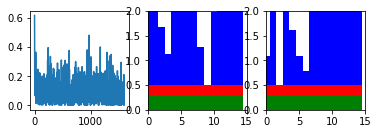

('New data, epoch', 1)
('Step', 0, 'Loss', 0.04820564, 'Acc', [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.5, 0.5, 0.49999997, 0.5])


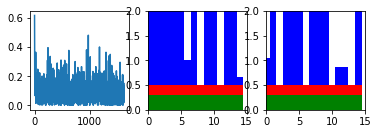

('Step', 100, 'Loss', 0.05630831, 'Acc', [0.5, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.49999997, 0.5, 0.49999997, 0.5, 0.5, 0.5, 0.49999997, 0.5, 0.5])


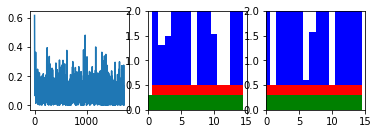

('Step', 200, 'Loss', 0.067044243, 'Acc', [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49999997])


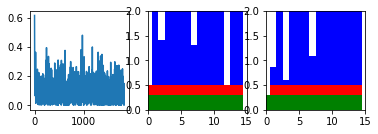

('Step', 300, 'Loss', 0.11041597, 'Acc', [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])


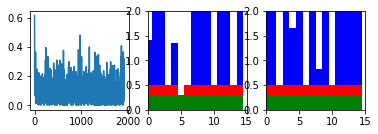

In [ ]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x, y = generateData(X_train.iloc[:, 2], y_train)
        
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            
            batchX = x[:, start_idx:end_idx]
            batchY = y[:, start_idx:end_idx]
            
            _total_loss, _train_step, _current_state, _predictions_series, _acc = sess.run(
                [total_loss, train_step, current_state, predictions_series, accuracy],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss, "Acc", _acc)
                plot(loss_list, _predictions_series, batchX, batchY)
    plt.ioff()
    plt.show()